$CO_2$ and $H_{total}$ equilibrium calculations. Thanks to Elad Noor for the initial implementation. 

In [1]:
%matplotlib inline 

import numpy as np
import pylab
import seaborn  # Just for styles, can be omitted.
from numpy import log, exp, linspace, matrix

from scipy.misc import logsumexp
seaborn.set_palette('colorblind')

In [2]:
dG0_H2O = -237.2 # kJ/mol
R = 8.31e-3 # kJ/(K*mol)
T = 298.15 # K

# Standard formation energies for every specie. Data from Alberty (2003). 
Alberty = {'CO2(g)':    {'nH':0, 'z':0,  'dG0_f': -394.36},
           'CO2(sp)':   {'nH':0, 'z':0,  'dG0_f': -385.97},
           'CO2(aq)':   {'nH':2, 'z':0,  'dG0_f': -385.97 - 237.13},
           'H2O(l)':    {'nH':2, 'z':0,  'dG0_f': -237.13},
           'H2CO3(sp)': {'nH':2, 'z':0,  'dG0_f': -606.33},
           'HCO3-(sp)': {'nH':1, 'z':-1, 'dG0_f': -586.77},
           'CO3-2(sp)': {'nH':0, 'z':-2, 'dG0_f': -527.81}}

# Pretty LaTeX style names for captions. 
PrettyNames = {'CO2(g)': r'$CO_2 Gas$',
               'CO2(sp)': r'$Aqueous CO_2$',
               'CO2(aq)': r'$Aqueous CO_2 + H_2O$',
               'H2O(l)': r'$H_20$',
               'H2CO3(sp)': r'$H_2CO_3$',
               'HCO3-(sp)': r'$HCO_3^-$',
               'CO3-2(sp)': r'$CO_3^{2-}$'}

# Mapping of KEGG IDs to protonation states of particular chemical species.
# Protonations states (AKA pseudoisomers) assumed to be in equilibrium with pH.
KEGG2sp = {'C00288': ['H2CO3(sp)', 'HCO3-(sp)', 'CO3-2(sp)'], # H_total
           'C00001': ['H2O(l)'],
           'C00011': ['CO2(sp)'],
           'C99998': ['CO2(aq)']} # False KEGG ID for CO2 + H2O

In [3]:
# Debye-Huckel
# Approximation of the temperature dependency of ionic strength effects
DH_alpha = 1e-3*(9.20483*T) - 1e-5*(1.284668 * T**2) + 1e-8*(4.95199 * T**3)
DH_beta = 1.6
def debye_huckel(I):
    """Approximation of the temperature dependency of ionic strength effects."""
    return DH_alpha * I**(0.5) / (1.0 + DH_beta * I**(0.5))

def transform(species, pH, I):
    """Calculates the dG' for the species group.
    
    Calculates a single formation energy for the entire group,
    transforming to account for the effect of pH and ionic strength
    at the absolute temperature specified above.
    
    Args:
        species: the identified for the group of species.
        pH: the pH.
        I: the ionic strength, molar units.
    """ 
    DH = debye_huckel(I)
    dG0_primes = []
    for d in map(Alberty.get, species):
        dG0_prime = d['dG0_f'] + \
                    d['nH'] * (R*T*log(10)*pH + DH) - \
                    d['z']**2 * DH
        dG0_primes.append(dG0_prime)
    dG0_prime_tot = -R*T * logsumexp([-x/(R*T) for x in dG0_primes])
    
    P = map(lambda x: exp((dG0_prime_tot - x)/(R*T)), dG0_primes)
    return dG0_prime_tot, dict(zip(species, P))

def calc_dG0_prime(sparse, pH, I):
    dG0_prime = 0
    for kegg_id, coeff in sparse.iteritems():
        dG0_prime += coeff * transform(KEGG2sp[kegg_id], pH, I)[0]
    return dG0_prime

In [4]:
# Calculate the pKas from dGf without DH correction for ionic strength.
h2co3_d   = Alberty['H2CO3(sp)']
hco3_d    = Alberty['HCO3-(sp)']
co3_d     = Alberty['CO3-2(sp)']
co2aq_d   = Alberty['CO2(aq)']
dGf_h2co3 = h2co3_d['dG0_f']
dGf_hco3  = hco3_d['dG0_f']
dGf_co3   = co3_d['dG0_f']
dGf_co2aq = co2aq_d['dG0_f']

pKa1 = (dGf_hco3 - dGf_h2co3) / (R*T*log(10))
pKa2 = (dGf_co3 - dGf_hco3) / (R*T*log(10))
pKa_eff = (dGf_hco3 - dGf_co2aq) / (R*T*log(10))
print 'H2CO3 pKas (I = 0)'
print 'pKa1 = %.2f' % pKa1
print 'pKa2 = %.2f' % pKa2
print 'pKa_eff = %.2f' % pKa_eff
print

# Calculate the pKas from dGf WITH DH correction for ionic strength.
ionic_s = .2 # in [M]
DH = debye_huckel(ionic_s)
dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
print 'H2CO3 pKas (I = %.2f [M])' % ionic_s
print 'pKa1 = %.2f' % pKa1
print 'pKa2 = %.2f' % pKa2
print 'pKa_eff = %.2f' % pKa_eff
print 

ionic_s = .05 # in [M]
DH = debye_huckel(ionic_s)
dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
print 'H2CO3 pKas (I = %.2f [M])' % ionic_s
print 'pKa1 = %.2f' % pKa1
print 'pKa2 = %.2f' % pKa2
print 'pKa_eff = %.2f' % pKa_eff
print

# assert that the acid and base have equal dG'0 in the calculated pKa:
np.testing.assert_almost_equal(transform(['HCO3-(sp)'], pKa1, ionic_s)[0],
                               transform(['H2CO3(sp)'], pKa1, ionic_s)[0])
np.testing.assert_almost_equal(transform(['CO3-2(sp)'], pKa2, ionic_s)[0],
                               transform(['HCO3-(sp)'], pKa2, ionic_s)[0])
np.testing.assert_almost_equal(transform(['CO2(aq)'],   pKa_eff, ionic_s)[0],
                               transform(['HCO3-(sp)'], pKa_eff, ionic_s)[0])

# Calculate dGr at specified pH and I
print 'Formation energy of CO2_total at pH 7, I = %.2f [M]' % ionic_s
print '%.2f kJ/mol' % transform(KEGG2sp['C00288'], 7, ionic_s)[0]
print

H2CO3 pKas (I = 0)
pKa1 = 3.43
pKa2 = 10.33
pKa_eff = 6.37

H2CO3 pKas (I = 0.20 [M])
pKa1 = 3.16
pKa2 = 9.80
pKa_eff = 6.10

H2CO3 pKas (I = 0.05 [M])
pKa1 = 3.26
pKa2 = 10.00
pKa_eff = 6.20

Formation energy of CO2_total at pH 7, I = 0.05 [M]
-546.84 kJ/mol



RuntimeError: maximum recursion depth exceeded

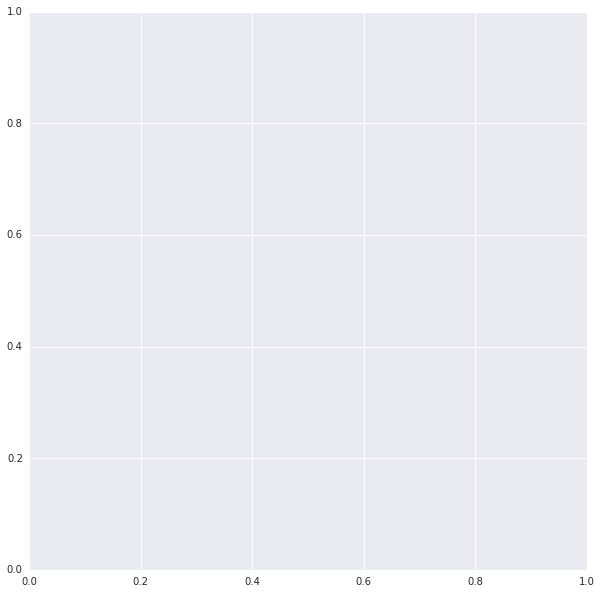

In [5]:
# Plot the pH dependence of the mole fraction of species in H_total.
data = []
pH_range = linspace(2, 14, 100)
species = KEGG2sp['C00288']
pretty_species = [PrettyNames[k] for k in species]
for pH in pH_range:
    dG0_prime, P_dict = transform(species, pH, 0.2)
    ordered_vals = [P_dict[k] for k in species]
    data.append(ordered_vals)

fractional_abundance = matrix(data)

pylab.figure(figsize=(10,10))
pylab.plot(pH_range, fractional_abundance, lw=4)

pylab.legend(pretty_species, loc='best')
leg = pylab.gca().get_legend()
ltext  = leg.get_texts()
pylab.setp(ltext, fontsize=16)

pylab.xlabel('pH', fontsize=20)
pylab.ylabel('Fractional Abundance', fontsize=20)
pylab.ylim((-0.05, 1.05))
pylab.xticks(fontsize=16)
pylab.yticks(fontsize=16)
pylab.savefig('htotal_equilibrium.pdf')
pylab.show()



In [ ]:
# Plot the response of hydration reaction dGr to pH at different I. 
def draw_pH_response(I, figure):
    sparse = {'C00001': -1, 'C00011': -1, 'C00288': 1}
    data = []
    pH_range = linspace(2, 14, 100)
    for pH in pH_range:
        data.append(calc_dG0_prime(sparse, pH, I))
    
    keq_data = np.exp(-np.array(data)/(R*T))
    pylab.plot(pH_range, keq_data, label='I = %.2f M' % I, lw=2, figure=figure)

fig = pylab.figure(figsize=(10,10))
pylab.yscale('log')
for I in [0, 0.05, 0.2]:
    draw_pH_response(I, fig)

pylab.xlabel('pH', fontsize=20)
pylab.ylabel('$K\'_{eq}$', fontsize=20)
pylab.title('$CO_2$ + $H_2O \leftrightarrow H_{total}$', fontsize=18)
pylab.xlim(5, 10)
pylab.ylim(1e-2, 1e5)
pylab.xticks(np.arange(5, 10.5, 0.5), fontsize=13)
pylab.yticks(fontsize=13)
pylab.legend()

pylab.show()

In [ ]:
# Partial pressures of CO2 and O2.
co2_pp = 400e-6
o2_pp = 0.21

# Solubility coefficients.
co2_solubility = 29.41 # L·atm/mol
o2_solubility = 769.2 # L·atm/mol

# Aqueous concentration when in equilibrium with the atmosphere.
co2_conc = co2_pp / co2_solubility
o2_conc = o2_pp / o2_solubility

print 'Aqueous gas concentrations at equilibrium'
print '[CO2] = %.1f uM' % (co2_conc * 1e6)
print '[O2] = %.1f uM' % (o2_conc * 1e6)

In [ ]:
# Plot the equilibrium concentration of dissolved inorganic carbon assuming
# that CO2 equilibrates with the atmosphere and then with H_total accoring to the pH. 
# I = 0.2 is towards the top of the biological range according to BNID 107522. 
I = 0.2
sparse = {'C00001': -1, 'C00011': -1, 'C00288': 1}  # Hydration of CO2 to H_total. 
pH_resp_dg = np.zeros(pH_range.size)
for i, pH in enumerate(pH_range):
    pH_resp_dg[i] = calc_dG0_prime(sparse, pH, I)

# Calculate the keq from dGr and then pH-dependence of Htotal conc.
keq = np.exp(-pH_resp_dg / (R*T))
h_total = keq * co2_conc
# Concentrations of H_total species follow mole fractions calculated above.
species_conc = np.multiply(fractional_abundance.T, h_total).T

pylab.figure(figsize=(10,10))
pylab.semilogy(pH_range, species_conc, lw=4, zorder=5)
pylab.semilogy(pH_range, h_total, lw=6, ls='--', zorder=10)
pylab.semilogy(pH_range, np.ones(pH_range.size) * co2_conc, lw=4, zorder=1)
pylab.semilogy(pH_range, np.ones(pH_range.size) * o2_conc, lw=4, zorder=1)

# Label exact concentrations of aqueous gasses on the plot. 
pylab.text(10.5, 1.8 * co2_conc, 'Aqueous [$CO_2$] = $%.1f {\mu}M$' % (co2_conc * 1e6),
           fontsize=13, fontweight='bold')
pylab.text(10.5, 1.8 * o2_conc, 'Aqueous [$O_2$] = $%.1f {\mu}M$' % (o2_conc * 1e6),
           fontsize=13, fontweight='bold')

# Labels for species in H_total
pretty_species_conc = ['[%s]' % ps for ps in pretty_species]
labels = pretty_species_conc + [r'$H_{total}$']

pylab.legend(labels, loc=2)
leg = pylab.gca().get_legend()
ltext  = leg.get_texts()
pylab.setp(ltext, fontsize=16)

pylab.xlabel('pH', fontsize=20)
pylab.ylabel('Concentration (M)', fontsize=20)
pylab.xlim((2, 12))
pylab.ylim((1e-17, 1e5))
pylab.xticks(np.arange(2,15), fontsize=13)
pylab.yticks(fontsize=13)
pylab.savefig('absolute_ci_conc.pdf')
pylab.show()

In [ ]:
# Plot the approximate effective permeability of HCO3- as a function of pH
# pKa1 as calculated above at I = 0.2 M. 
pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))

# Effective permeability as derived in SI. 
P_h2co3 = 3e-3  # cm/s
Peff_hco3 = P_h2co3 * np.power(10, pKa1 - pH_range)

pylab.figure(figsize=(10,10))
pylab.semilogy(pH_range, Peff_hco3, lw=3)
pylab.axvline(4.35, lw=2, ls='--')
pylab.text(3.95, 1e-8, u'$k_m = 3$\u00D7$10^{-4}$ as in earlier model',
           rotation=90, fontsize=13)

pylab.xlabel('pH', fontsize=20)
pylab.ylabel('$k_m^{H_{total}}$', fontsize=20)
pylab.xticks(np.arange(2,15), fontsize=13)
pylab.yticks(fontsize=13)
pylab.show()

In [ ]:
h_total = 5e-3
co2_conc = h_total / keq